## BT4222 Project - Toxic Comments Classifier (Deep Learning Modelling)
In this notebook, we will perform word embeddings and deep learning techniques taught in class. We will primarily be doing gloVe, FastText embeddings and model with LSTM and CNN models. For full elaboration of the result, please refer to the report.

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import io
import re
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
import pickle
import gc

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer

from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

### Data Preprocessing

In [2]:
def Sanitize(df, comment_text):
    emoji_dict = defaultdict()
    with io.open('emoji_unicode_names_final.txt', 'r', encoding="utf8") as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.strip().split('\t')
            emoji_dict[tokens[0]] = tokens[1]
    repl = {
    "&lt;3": " good ",
    ":d": " good ",
    ":dd": " good ",
    ":p": " good ",
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",
    "yay!": " good ",
    "yay": " good ",
    "yaay": " good ",
    "yaaay": " good ",
    "yaaaay": " good ",
    "yaaaaay": " good ",
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " bad ",
    ":(": " bad ",
    ":s": " bad ",
    ":-s": " bad ",
    "&lt;3": " heart ",
    ":d": " smile ",
    ":p": " smile ",
    ":dd": " smile ",
    "8)": " smile ",
    ":-)": " smile ",
    ":)": " smile ",
    ";)": " smile ",
    "(-:": " smile ",
    "(:": " smile ",
    ":/": " worry ",
    ":&gt;": " angry ",
    ":')": " sad ",
    ":-(": " sad ",
    ":(": " sad ",
    ":s": " sad ",
    ":-s": " sad ",
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
    r"\bi'm\b": "i am",
    "m": "am",
    "r": "are",
    "u": "you",
    "haha": "ha",
    "hahaha": "ha",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "can't": "can not",
    "cannot": "can not",
    "i'm": "i am",
    "m": "am",
    "i'll" : "i will",
    "its" : "it is",
    "it's" : "it is",
    "'s" : " is",
    "that's" : "that is",
    "weren't" : "were not",
    }

    keys = [i for i in repl.keys()]
    ltr = df[comment_text].tolist()
    new_train_data = []
    stopwords_en = stopwords.words('english')
    for i in ltr:
        arr = str(i).split()
        xx = ""
        for j in arr:
            j = str(j).lower()
            if j[:4] == 'http' or j[:3] == 'www':
                continue
            if j in keys:
                # print("inn")
                j = repl[j]
            if j in emoji_dict:
                j = emoji_dict[j]
            xx += j + " "
        new_train_data.append(xx)
    df[comment_text] = new_train_data
    
    comment = comment_text
    
    df[comment] = df[comment].str.lower().str.replace('newline_token', ' ')
    df[comment] = df[comment].fillna('erikov')
    #special symbols
    df[comment] = df[comment].apply(lambda x : " ".join(re.findall('[\w]+',x)))
    #stop words
    #df[comment] = df[comment].apply(lambda x: self.remove_stopwords(x, stopwords_en))
    #websites
    df[comment] = df[comment].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
    df[comment] = df[comment].replace(r'@[^\s]+[\s]?', '', regex=True)
    #ip address
    df[comment] = df[comment].replace(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', regex=True)
    
    df[comment] = df[comment].replace('&', ' and ', regex=True)
    df[comment] = df[comment].replace('@', ' at ', regex=True)
    df[comment] = df[comment].replace('0', ' zero ', regex=True)
    df[comment] = df[comment].replace('1', ' one ', regex=True)
    df[comment] = df[comment].replace('2', ' two ', regex=True)
    df[comment] = df[comment].replace('3', ' three ', regex=True)
    df[comment] = df[comment].replace('4', ' four ', regex=True)
    df[comment] = df[comment].replace('5', ' five ', regex=True)
    df[comment] = df[comment].replace('6', ' six ', regex=True)
    df[comment] = df[comment].replace('7', ' seven ', regex=True)
    df[comment] = df[comment].replace('8', ' eight ', regex=True)
    df[comment] = df[comment].replace('9', ' nine ', regex=True)
    #multi space
    df[comment] = df[comment].replace('\s+', ' ', regex=True)
    
    return df

In [3]:
def Sanitize2(df,comment_text):
    stop_words = stopwords.words('english')
    stop_words = stop_words + ["br","a"] 
        
    text_data = df[comment_text].tolist()
    text_data = [simple_preprocess(text,deacc=True) for text in text_data] 
    text_data = [[token for token in text if token not in stop_words] for text in text_data]
    text_data = [" ".join(text) for text in text_data]
    df[comment_text] = text_data
    
    return df

In [4]:
df = pd.read_csv('train.csv')
df = Sanitize(df, 'comment_text')
df = Sanitize2(df, 'comment_text')

In [5]:
df1 = pd.read_csv('test.csv')
df2 = pd.read_csv('test_labels.csv')
df1 = pd.merge(df1, df2, on='id')
df1 = df1[df1['toxic']!=-1]
df1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [6]:
df1 = Sanitize(df1, 'comment_text')
df1 = Sanitize2(df1, 'comment_text')
df1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,thank understanding think highly would revert ...,0,0,0,0,0,0
7,000247e83dcc1211,dear god site horrible,0,0,0,0,0,0
11,0002f87b16116a7f,somebody invariably try add religion really me...,0,0,0,0,0,0
13,0003e1cccfd5a40a,says right type type institution needed case t...,0,0,0,0,0,0
14,00059ace3e3e9a53,adding new product list make sure relevant add...,0,0,0,0,0,0


### Feature Preprocesssing - Creating word vectors

In [7]:
train_input = list(df['comment_text'].values)
test_input = list(df1['comment_text'].values)

In [8]:
# Padding on word vectors for lstm models
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_input)
list_tokenized_train = tokenizer.texts_to_sequences(train_input)
list_tokenized_test = tokenizer.texts_to_sequences(test_input)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [9]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = df[list_classes].values
y_te = df1[list_classes].values

### Prepare embeddings

In [47]:
EMBEDDING_FILE = 'glove.6B.50d.txt'

max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

embed_size = 50

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf8"))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [48]:
glove_matrix = embedding_matrix

In [49]:
glove_matrix.shape

(20000, 50)

In [50]:
EMBEDDING_FILE = 'crawl-300d-2M.vec'

max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

embed_size = 300

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf8"))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
embeddedCount = 0
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
print('total embedded:', embeddedCount, 'common words')

In [51]:
fasttext_matrix = embedding_matrix

In [52]:
fasttext_matrix.shape

(20000, 300)

### LSTM Modelling

In [20]:
#Use bidirectional lstm model
embed_size = 128
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(LSTM(50, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                        optimizer='adam', metrics=['accuracy'])
batch_size = 32
epochs = 2
history = model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
# list all data in history

C:\Users\danny\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 781s 5ms/step - loss: 0.0645 - accuracy: 0.9784 - val_loss: 0.0516 - val_accuracy: 0.9812
Epoch 2/2
143613/143613 [==============================] - 620s 4ms/step - loss: 0.0453 - accuracy: 0.9831 - val_loss: 0.0498 - val_accuracy: 0.9817


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


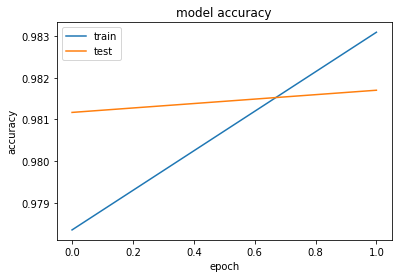

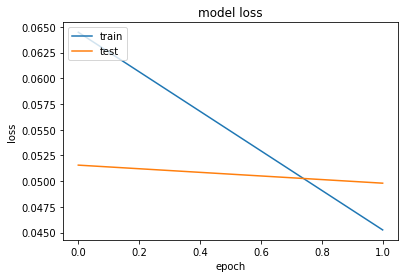

In [21]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

pickle.dump(model, open('lstm_pickle', 'wb'))

In [94]:
#Use bidirectional lstm model with gloVe embeddings
embed_size = 50
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[glove_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 32
epochs = 2
history = model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
# list all data in history

C:\Users\danny\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1928s 13ms/step - loss: 0.0603 - accuracy: 0.9792 - val_loss: 0.0490 - val_accuracy: 0.9815
Epoch 2/2
143613/143613 [==============================] - 1914s 13ms/step - loss: 0.0449 - accuracy: 0.9829 - val_loss: 0.0470 - val_accuracy: 0.9824


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


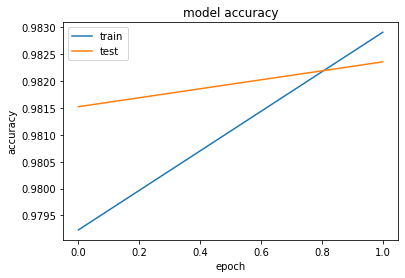

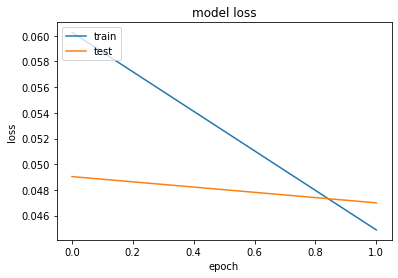

In [95]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

pickle.dump(model, open('lstm_glove_pickle', 'wb'))

In [97]:
#Use bidirectional lstm model with fastText embeddings
embed_size = 300
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[fasttext_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 32
epochs = 2
history = model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
# list all data in history

C:\Users\danny\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 6139s 43ms/step - loss: 0.0537 - accuracy: 0.9810 - val_loss: 0.0478 - val_accuracy: 0.9818
Epoch 2/2
143613/143613 [==============================] - 6239s 43ms/step - loss: 0.0403 - accuracy: 0.9845 - val_loss: 0.0466 - val_accuracy: 0.9827


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


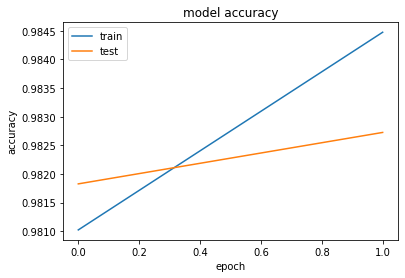

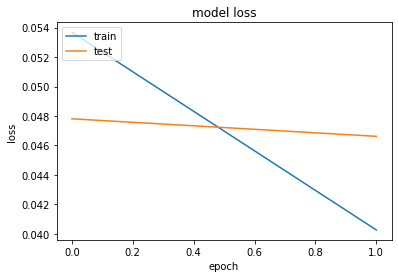

In [98]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

pickle.dump(model, open('lstm_fasttext_pickle', 'wb'))

### CNN Modelling

In [102]:
embed_size = 50
lr = 1e-3
lr_d = 0
units = 128
dr = 0.2
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = SpatialDropout1D(dr)(x)
x = Bidirectional(GRU(units, return_sequences = True))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(6, activation = "sigmoid")(x)
model = Model(inputs = inp, outputs = x)
model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
batch_size = 128
epochs = 4
history = model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

C:\Users\danny\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143613/143613 [==============================] - 5733s 40ms/step - loss: 0.0669 - accuracy: 0.9784 - val_loss: 0.0531 - val_accuracy: 0.9806
Epoch 2/4
143613/143613 [==============================] - 5568s 39ms/step - loss: 0.0461 - accuracy: 0.9829 - val_loss: 0.0506 - val_accuracy: 0.9814
Epoch 3/4
143613/143613 [==============================] - 5642s 39ms/step - loss: 0.0403 - accuracy: 0.9847 - val_loss: 0.0509 - val_accuracy: 0.9813
Epoch 4/4
143613/143613 [==============================] - 5798s 40ms/step - loss: 0.0349 - accuracy: 0.9867 - val_loss: 0.0547 - val_accuracy: 0.9808


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


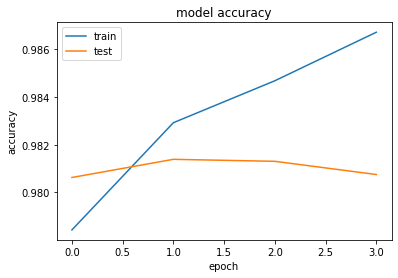

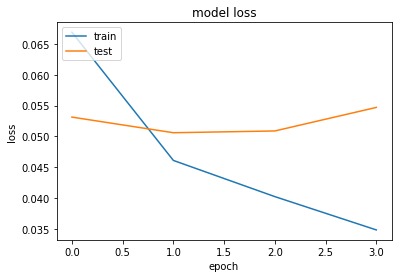

In [103]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

pickle.dump(model, open('cnn_pickle', 'wb'))

In [100]:
embed_size = 50
lr = 1e-3
lr_d = 0
units = 128
dr = 0.2
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [glove_matrix], trainable = False)(inp)
x = SpatialDropout1D(dr)(x)
x = Bidirectional(GRU(units, return_sequences = True))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(6, activation = "sigmoid")(x)
model = Model(inputs = inp, outputs = x)
model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
batch_size = 128
epochs = 4
history = model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143613/143613 [==============================] - 5449s 38ms/step - loss: 0.0726 - accuracy: 0.9753 - val_loss: 0.0589 - val_accuracy: 0.9795
Epoch 2/4
143613/143613 [==============================] - 5319s 37ms/step - loss: 0.0582 - accuracy: 0.9794 - val_loss: 0.0560 - val_accuracy: 0.9799
Epoch 3/4
143613/143613 [==============================] - 5452s 38ms/step - loss: 0.0544 - accuracy: 0.9805 - val_loss: 0.0534 - val_accuracy: 0.9803
Epoch 4/4
143613/143613 [==============================] - 5544s 39ms/step - loss: 0.0520 - accuracy: 0.9811 - val_loss: 0.0523 - val_accuracy: 0.9807


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


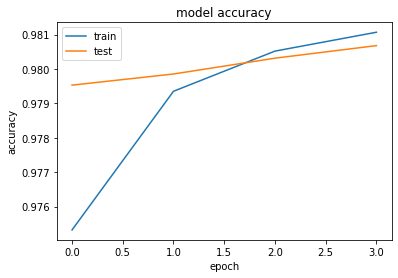

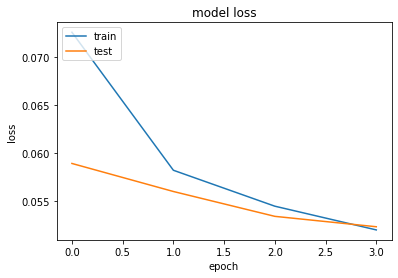

In [101]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

pickle.dump(model, open('cnn_glove_pickle', 'wb'))

In [104]:
embed_size = 300
lr = 1e-3
lr_d = 0
units = 128
dr = 0.2
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [fasttext_matrix], trainable = False)(inp)
x = SpatialDropout1D(dr)(x)
x = Bidirectional(GRU(units, return_sequences = True))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(6, activation = "sigmoid")(x)
model = Model(inputs = inp, outputs = x)
model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
batch_size = 128
epochs = 4
history = model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143613/143613 [==============================] - 10359s 72ms/step - loss: 0.0586 - accuracy: 0.9792 - val_loss: 0.0495 - val_accuracy: 0.9820
Epoch 2/4
143613/143613 [==============================] - 10161s 71ms/step - loss: 0.0459 - accuracy: 0.9829 - val_loss: 0.0472 - val_accuracy: 0.9828
Epoch 3/4
143613/143613 [==============================] - 9796s 68ms/step - loss: 0.0436 - accuracy: 0.9835 - val_loss: 0.0478 - val_accuracy: 0.9820
Epoch 4/4
143613/143613 [==============================] - 9799s 68ms/step - loss: 0.0412 - accuracy: 0.9843 - val_loss: 0.0457 - val_accuracy: 0.9827


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


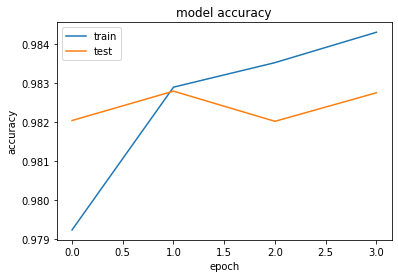

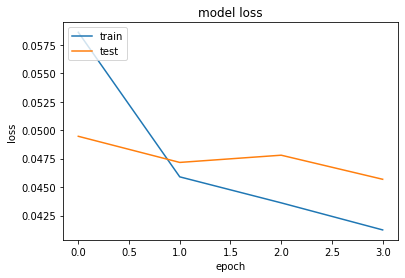

In [105]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

pickle.dump(model, open('cnn_fasttext_pickle', 'wb'))

### Performance

In [22]:
lstm_model = pickle.load(open('lstm_pickle', 'rb'))
y_pred = lstm_model.predict(X_te)
lstm_y_pred_labels = []
for row in y_pred:
    lstm_y_pred_labels.append([int(i) for i in row > 0.5])
roc_auc_score(y_te, lstm_y_pred_labels)

C:\Users\danny\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.7203042061853745

In [25]:
lstm_glove_model = pickle.load(open('lstm_glove_pickle', 'rb'))
y_pred = lstm_glove_model.predict(X_te)
lstm_glove_y_pred_labels = []
for row in y_pred:
    lstm_glove_y_pred_labels.append([int(i) for i in row > 0.5])
roc_auc_score(y_te, lstm_glove_y_pred_labels)

C:\Users\danny\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.7218909267515943

In [26]:
lstm_fasttext_model = pickle.load(open('lstm_fasttext_pickle', 'rb'))
y_pred = lstm_fasttext_model.predict(X_te)
lstm_fasttext_y_pred_labels = []
for row in y_pred:
    lstm_fasttext_y_pred_labels.append([int(i) for i in row > 0.5])
roc_auc_score(y_te, lstm_fasttext_y_pred_labels)

C:\Users\danny\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.7358418747457489

In [17]:
cnn_model = pickle.load(open('cnn_pickle', 'rb'))
y_pred = cnn_model.predict(X_te)
cnn_y_pred_labels = []
for row in y_pred:
    cnn_y_pred_labels.append([int(i) for i in row > 0.5])
roc_auc_score(y_te, cnn_y_pred_labels)

C:\Users\danny\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.7524505429305831

In [16]:
cnn_glove_model = pickle.load(open('cnn_glove_pickle', 'rb'))
y_pred = cnn_glove_model.predict(X_te)
cnn_glove_y_pred_labels = []
for row in y_pred:
    cnn_glove_y_pred_labels.append([int(i) for i in row > 0.5])
roc_auc_score(y_te, cnn_glove_y_pred_labels)

0.741486170931891

In [27]:
cnn_fasttext_model = pickle.load(open('cnn_fasttext_pickle', 'rb'))
y_pred = cnn_fasttext_model.predict(X_te)
cnn_fasttext_y_pred_labels = []
for row in y_pred:
    cnn_fasttext_y_pred_labels.append([int(i) for i in row > 0.5])
roc_auc_score(y_te, cnn_fasttext_y_pred_labels)

0.8078419074038402

### Optimisation

In [11]:
lstm_fasttext_model = pickle.load(open('lstm_fasttext_pickle', 'rb'))
y_pred = lstm_fasttext_model.predict(X_t)
#Try different benchmark values
benchmark_values = [0.05, 0.075, 0.1, 0.3, 0.5]
for benchmark in benchmark_values:
    lstm_fasttext_ytrain_pred_labels = []
    for row in y_pred:
        lstm_fasttext_ytrain_pred_labels.append([int(i) for i in row > benchmark])
    print(roc_auc_score(y, lstm_fasttext_ytrain_pred_labels))

0.950077957583241
0.9419559143971491
0.9331824653381303
0.8469139049274004
0.7498184414591579


In [23]:
lstm_fasttext_model = pickle.load(open('lstm_fasttext_pickle', 'rb'))
y_pred = lstm_fasttext_model.predict(X_te)
lstm_fasttext_y_pred_labels = []
for row in y_pred:
    lstm_fasttext_y_pred_labels.append([int(i) for i in row > 0.1])
roc_auc_score(y_te, lstm_fasttext_y_pred_labels)

C:\Users\danny\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.9008881400143401

In [14]:
cnn_fasttext_model = pickle.load(open('cnn_fasttext_pickle', 'rb'))
y_pred = cnn_fasttext_model.predict(X_t)
#Try different benchmark values
benchmark_values = [0.05, 0.075, 0.1, 0.3, 0.5]
for benchmark in benchmark_values:
    cnn_fasttext_ytrain_pred_labels = []
    for row in y_pred:
        cnn_fasttext_ytrain_pred_labels.append([int(i) for i in row > benchmark])
    print(roc_auc_score(y, cnn_fasttext_ytrain_pred_labels))

0.9476332878012276
0.9429232847593637
0.9353211381347224
0.8743972069061798
0.809551228821834


In [24]:
cnn_fasttext_model = pickle.load(open('cnn_fasttext_pickle', 'rb'))
y_pred = cnn_fasttext_model.predict(X_te)
cnn_fasttext_y_pred_labels = []
for row in y_pred:
    cnn_fasttext_y_pred_labels.append([int(i) for i in row > 0.1])
roc_auc_score(y_te, cnn_fasttext_y_pred_labels)

0.9159975425568326

### Correlation between models

In [25]:
for i in range(6):
    lst = [k[i] for k in y_te]
    lst1 = [k[i] for k in lstm_fasttext_y_pred_labels]
    lst2 = [k[i] for k in cnn_fasttext_y_pred_labels]
    print(i)
    print(np.corrcoef(lst1,lst2))
    print(accuracy_score(lst, lst1))
    print(accuracy_score(lst, lst2))

0
[[1.         0.81601199]
 [0.81601199 1.        ]]
0.8580293225796367
0.8503079183469318
1
[[1.         0.75248383]
 [0.75248383 1.        ]]
0.9757104004501548
0.9692237956797649
2
[[1.         0.85530089]
 [0.85530089 1.        ]]
0.9202694676294977
0.9075307136828284
3
[[1.       0.702594]
 [0.702594 1.      ]]
0.9934039826190253
0.9914345556284972
4
[[1.         0.84521099]
 [0.84521099 1.        ]]
0.9043733783488074
0.9005283066053956
5
[[1.        0.7379217]
 [0.7379217 1.       ]]
0.9817906155240864
0.9792584951076932


### Stacking

In [26]:
# Base Learner 1
lstm_fasttext_model = pickle.load(open('lstm_fasttext_pickle', 'rb'))
ytrain_pred = lstm_fasttext_model.predict(X_t)
lstm_fasttext_ytrain_pred_labels = []
for row in ytrain_pred:
    lstm_fasttext_ytrain_pred_labels.append([int(i) for i in row > 0.1])

# Base learner 2
cnn_fasttext_model = pickle.load(open('cnn_fasttext_pickle', 'rb'))
ytrain_pred = cnn_fasttext_model.predict(X_t)
cnn_fasttext_ytrain_pred_labels = []
for row in ytrain_pred:
    cnn_fasttext_ytrain_pred_labels.append([int(i) for i in row > 0.1])

C:\Users\danny\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [27]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
dic1 = {}
dic2 = {}
for i in range(6):
    lst1 = [k[i] for k in lstm_fasttext_ytrain_pred_labels]
    lst2 = [k[i] for k in cnn_fasttext_ytrain_pred_labels]
    lst3 = [k[i] for k in lstm_fasttext_y_pred_labels]
    lst4 = [k[i] for k in cnn_fasttext_y_pred_labels]
    dic1[('lstm_'+classes[i])] = lst1
    dic1[('cnn_'+classes[i])] = lst2
    dic2[('lstm_'+classes[i])] = lst3
    dic2[('cnn_'+classes[i])] = lst4
df3 = pd.DataFrame(dic1)
df4 = pd.DataFrame(dic2)

In [28]:
df3.head()

,lstm_toxic,cnn_toxic,lstm_severe_toxic,cnn_severe_toxic,lstm_obscene,cnn_obscene,lstm_threat,cnn_threat,lstm_insult,cnn_insult,lstm_identity_hate,cnn_identity_hate
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
## Stacking for each class labels
from sklearn.linear_model import LogisticRegression
stack_scores = []
for var in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    log_model = LogisticRegression(random_state = 1234, C= 0.01)
    log_model.fit(df3[[('lstm_'+var), ('cnn_'+var)]] ,  df[var].values)
    y_pred = log_model.predict(df4[[('lstm_'+var), ('cnn_'+var)]])
    stack_scores.append(roc_auc_score(df1[var].values, y_pred))

C:\Users\danny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\danny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\danny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\danny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\danny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [30]:
sum(stack_scores)/5

0.8494837458331241